# Survival Analysis of PBTA splicing data
### Author: Shehbeel Arif
### Affiliation: Center for Data-driven Discovery in Biomedicine (D3b), The Children's Hospital of Philadelphia
### Contact: arifs2@chop.edu
### Goal: To find prognostic splicing sites that correlate with overall survival (OS)

In [1]:
# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Modeling libraries
import joblib
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline

# Survival Libraries
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
# Load OpenPBTA splicing dataset
#data_dir = "/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/Ammar_splicing/data/"
data_dir = "/Users/shehbeel/Documents/Ammar_splicing/data/"
results_dir = "/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/results/"

df = pd.read_csv(data_dir + "pan_cancer_splicing_SE.rg.gene.fitlered.uniq.txt", sep="\t", header=None)
header = pd.read_csv(data_dir + "splicing_header.txt", sep="\t")
meta = pd.read_csv(data_dir + "histologies.tsv", sep="\t", low_memory=False)

# Add header to splicing matrix
df.columns = header.columns
# Set 'Splice_ID' as index
df = df.set_index('Splice_ID')
# Transpose the matrix
tdf = df.T
# Make 'Splicing_ID' index as column and change name to 'Kids_First_Biospecimen_ID'
tdf = tdf.reset_index()
tdf = tdf.rename({'index':'Kids_First_Biospecimen_ID'}, axis=1)

# Merge meta data and splicing matrix
dfm = pd.merge(meta, tdf, on='Kids_First_Biospecimen_ID')

dfm

Kids_First_Biospecimen_ID  sample_id aliquot_id  \
0                  BS_014EVM2D   7316-362     570113   
1                  BS_02NZT8CE  7316-1745     549619   
2                  BS_03FT4S8B  7316-1671     654203   
3                  BS_0448A413   7316-364     570114   
4                  BS_044XZ8ST  7316-3570     711744   
...                        ...        ...        ...   
1022               BS_ZWR9W4FX  7316-1653     717103   
1023               BS_ZXYDSBM9   7316-739     731886   
1024               BS_ZZMYDZJW   7316-436     564451   
1025               BS_ZZPBANDD  7316-1941     588347   
1026               BS_ZZWMD6FA  7316-2901     711701   

     Kids_First_Participant_ID experimental_strategy sample_type  \
0                  PT_S21ZTKPS               RNA-Seq       Tumor   
1                  PT_2BJF83GQ               RNA-Seq       Tumor   
2                  PT_5KRVE8E4               RNA-Seq       Tumor   
3                  PT_VHS5RM2K               RNA-Seq       Tumor   
4                  PT_QAX38GM7               RNA-Seq       Tumor   
...                        ...                   ...         ...   
1022               PT_4RJ2EATN               RNA-Seq       Tumor   
1023               PT_R63RHJWX               RNA-Seq       Tumor   
1024               PT_5M8A47WW               RNA-Seq       Tumor   
1025               PT_9YNQJZ5G               RNA-Seq       Tumor   
1026               PT_RGX23JFP               RNA-Seq       Tumor   

       composition   tumor_descriptor                           primary_site  \
0     Solid Tissue  Initial CNS Tumor                          Temporal Lobe   
1     Solid Tissue        Progressive            Optic Pathway;Temporal Lobe   
2     Solid Tissue  Initial CNS Tumor     Suprasellar/Hypothalamic/Pituitary   
3     Solid Tissue  Initial CNS Tumor                          Temporal Lobe   
4     Solid Tissue        Progressive                          Parietal Lobe   
...            ...                ...                                    ...   
1022  Solid Tissue  Initial CNS Tumor     Suprasellar/Hypothalamic/Pituitary   
1023  Solid Tissue  Initial CNS Tumor  Cerebellum/Posterior Fossa;Ventricles   
1024  Solid Tissue  Initial CNS Tumor             Cerebellum/Posterior Fossa   
1025  Solid Tissue        Progressive                          Temporal Lobe   
1026  Solid Tissue        Progressive            Parietal Lobe;Temporal Lobe   

     reported_gender  ...  \
0             Female  ...   
1             Female  ...   
2             Female  ...   
3               Male  ...   
4               Male  ...   
...              ...  ...   
1022          Female  ...   
1023            Male  ...   
1024          Female  ...   
1025          Female  ...   
1026          Female  ...   

     ZXDC_126441765-126441946_126439631-126439727_126459652-126459737  \
0                                                   0.0                 
1                                                   0.0                 
2                                                   0.0                 
3                                                   0.0                 
4                                                   0.0                 
...                                                 ...                 
1022                                                0.0                 
1023                                                0.0                 
1024                                                0.0                 
1025                                                0.0                 
1026                                                0.0                 

     ZXDC_126441765-126441946_126439631-126439727_126461269-126462220  \
0                                                   0.0                 
1                                                   0.0                 
2                                                   0.0                 
3                                   

In [4]:
# Drop duplicates if present; A single 'sample_id' can have multiple 'Kids_First_Biospecimen_ID's
dfm = dfm.drop_duplicates(subset='sample_id')
# Drop NAs present in OS_survival column
dfms = dfm.dropna(subset=['OS_days', 'OS_status'])

dfms

Kids_First_Biospecimen_ID  sample_id aliquot_id  \
0                  BS_014EVM2D   7316-362     570113   
1                  BS_02NZT8CE  7316-1745     549619   
3                  BS_0448A413   7316-364     570114   
4                  BS_044XZ8ST  7316-3570     711744   
5                  BS_052PZFMK  7316-1099     470025   
...                        ...        ...        ...   
1021               BS_ZVZDDW2G  7316-2664     711710   
1022               BS_ZWR9W4FX  7316-1653     717103   
1023               BS_ZXYDSBM9   7316-739     731886   
1024               BS_ZZMYDZJW   7316-436     564451   
1026               BS_ZZWMD6FA  7316-2901     711701   

     Kids_First_Participant_ID experimental_strategy sample_type  \
0                  PT_S21ZTKPS               RNA-Seq       Tumor   
1                  PT_2BJF83GQ               RNA-Seq       Tumor   
3                  PT_VHS5RM2K               RNA-Seq       Tumor   
4                  PT_QAX38GM7               RNA-Seq       Tumor   
5                  PT_N3205P0D               RNA-Seq       Tumor   
...                        ...                   ...         ...   
1021               PT_E3ADF4ZB               RNA-Seq       Tumor   
1022               PT_4RJ2EATN               RNA-Seq       Tumor   
1023               PT_R63RHJWX               RNA-Seq       Tumor   
1024               PT_5M8A47WW               RNA-Seq       Tumor   
1026               PT_RGX23JFP               RNA-Seq       Tumor   

       composition   tumor_descriptor                           primary_site  \
0     Solid Tissue  Initial CNS Tumor                          Temporal Lobe   
1     Solid Tissue        Progressive            Optic Pathway;Temporal Lobe   
3     Solid Tissue  Initial CNS Tumor                          Temporal Lobe   
4     Solid Tissue        Progressive                          Parietal Lobe   
5     Solid Tissue  Initial CNS Tumor             Frontal Lobe;Parietal Lobe   
...            ...                ...                                    ...   
1021  Solid Tissue  Initial CNS Tumor                           Frontal Lobe   
1022  Solid Tissue  Initial CNS Tumor     Suprasellar/Hypothalamic/Pituitary   
1023  Solid Tissue  Initial CNS Tumor  Cerebellum/Posterior Fossa;Ventricles   
1024  Solid Tissue  Initial CNS Tumor             Cerebellum/Posterior Fossa   
1026  Solid Tissue        Progressive            Parietal Lobe;Temporal Lobe   

     reported_gender  ...  \
0             Female  ...   
1             Female  ...   
3               Male  ...   
4               Male  ...   
5               Male  ...   
...              ...  ...   
1021            Male  ...   
1022          Female  ...   
1023            Male  ...   
1024          Female  ...   
1026          Female  ...   

     ZXDC_126441765-126441946_126439631-126439727_126459652-126459737  \
0                                                   0.0                 
1                                                   0.0                 
3                                                   0.0                 
4                                                   0.0                 
5                                                   0.0                 
...                                                 ...                 
1021                                                0.0                 
1022                                                0.0                 
1023                                                0.0                 
1024                                                0.0                 
1026                                                0.0                 

     ZXDC_126441765-126441946_126439631-126439727_126461269-126462220  \
0                                                   0.0                 
1                                                   0.0                 
3                                                   0.0                 
4                                   

In [5]:
# Convert 'OS_status' to TRUE and FALSE
dfms['OS_status'] = dfms['OS_status'].map({'DECEASED':True, 'LIVING':False})
dfms.to_csv(results_dir + 'pbta_splicing.csv', index=False)

/var/folders/dt/gtzg6wys47bbxzctx45shfkm0000gn/T/ipykernel_44505/3064933723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfms['OS_status'] = dfms['OS_status'].map({'DECEASED':True, 'LIVING':False})


In [6]:
def plot_alphas(gcv, model_num):
    cv_results = pd.DataFrame(gcv.cv_results_)
    
    alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
    mean = cv_results.mean_test_score
    std = cv_results.std_test_score

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(alphas, mean)
    ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
    ax.set_xscale("log")
    ax.set_title(f"Model# {model_num}; CI : {max(mean)}")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)

---

# All brain tumors

In [7]:
# Split into training and testing set
# Select only splicing sites columns for X feature matrix
X = dfms.iloc[:,46:]

# Normalize the splicing features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fits and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Add column names back into normalized dataframe
Xs.columns = X.columns

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])
print(Xs.head(5))

# Select only OS_status and OS_days columns for y labels
y = dfms[['OS_status', 'OS_days']]
# Convert y (boolean censor and OS_surival) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_status': 'bool', 'OS_days':'f8'})
print(y)

   A1BG-AS1_58353321-58353474_58347750-58347844_58353713-58353857  \
0                                          -0.198528                
1                                          -0.198528                
2                                          -0.198528                
3                                          -0.198528                
4                                          -0.198528                

   A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857  \
0                                          -0.401887                
1                                          -0.401887                
2                                          -0.401887                
3                                          -0.401887                
4                                          -0.401887                

   A2ML1_8836255-8836339_8835506-8835666_8837439-8837566  \
0                                          -0.034159       
1                                          -0.0341

In [8]:
## Grid-Search to find optimal model parameters and conduct feature selection

penalty_factor = np.ones(Xs.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_models/all_coxnet_feb27/gcv_splicing_v{version}.pkl"


joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_stats/all_coxnet_feb27/stats_splicing_v{version}.pkl")


results

/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to 0.5.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxnet.py", line 249, in f

l1 best : 0.05
 non-zero: 549


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
232       0.456917      0.009398         0.098464        0.000461   
253       0.447098      0.007034         0.099060        0.000323   
128       0.443067      0.033585         0.101182        0.001565   
358       0.409486      0.007793         0.098908        0.000542   
316       0.423182      0.012412         0.099449        0.000443   
..             ...           ...              ...             ...   
291       0.354319      0.003602         0.099751        0.000676   
292       0.363688      0.004213         0.105124        0.006081   
293       0.388860      0.035681         0.102839        0.003315   
166       0.355129      0.005968         0.099114        0.000550   
419       0.360472      0.001845         0.100589        0.000607   

    param_coxnetsurvivalanalysis__alphas  \
232                               [0.55]   
253                 [0.6000000000000001]   
128                [0.30000000000000004]   
358                 [0.8500000000000001]   
316                               [0.75]   
..                                   ...   
291                               [0.65]   
292                               [0.65]   
293                               [0.65]   
166                [0.35000000000000003]   
419                 [0.9500000000000001]   

    param_coxnetsurvivalanalysis__l1_ratio  \
232                                   0.05   
253                                   0.05   
128                                    0.1   
358                                   0.05   
316                                   0.05   
..                                     ...   
291                                    0.9   
292                                   0.95   
293                                      1   
166                                   0.95   
419                                      1   

                                                params  split0_test_score  \
232  {'coxnetsurvivalanalysis__alphas': [0.55], 'co...           0.841428   
253  {'coxnetsurvivalanalysis__alphas': [0.60000000...           0.839975   
128  {'coxnetsurvivalanalysis__alphas': [0.30000000...           0.839975   
358  {'coxnetsurvivalanalysis__alphas': [0.85000000...           0.840909   
316  {'coxnetsurvivalanalysis__alphas': [0.75], 'co...           0.842985   
..                                                 ...                ...   
291  {'coxnetsurvivalanalysis__alphas': [0.65], 'co...           0.522468   
292  {'coxnetsurvivalanalysis__alphas': [0.65], 'co...           0.522468   
293  {'coxnetsurvivalanalysis__alphas': [0.65], 'co...           0.522468   
166  {'coxnetsurvivalanalysis__alphas': [0.35000000...           0.522468   
419  {'coxnetsurvivalanalysis__alphas': [0.95000000...           0.522468   

     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
232           0.893572           0.815652           0.846787         0.849360   
253           0.895328           0.811613           0.847761         0.848669   
128           0.895094           0.809758           0.847849         0.848169   
358           0.892636           0.805174           0.851655         0.847593   
316           0.894158           0.805174           0.847141         0.847364   
..                 ...                ...                ...              ...   
291           0.499415           0.469876           0.477120         0.492219   
292           0.499415           0.469876           0.477120         0.492219   
293           0.499415           0.469876           0.477120         0.492219   
166           0.499415           0.469876           0.477120         0.492219   
419           0.499415           0.469876           0.477120         0.492219   

     std_test_score  rank_test_score  
232        0.028109                1  
253        0.030111                2  
128        0.030597                3  
358        0.031183                4  
3

In [9]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

# _, ax = plt.subplots(figsize=(6, 40))
# non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
# ax.set_xlabel("coefficient")
# ax.grid(True)

Number of non-zero coefficients: 549


In [10]:
# Export top ranked prognostic splicing sites for MB
ranked_prognostic_splicing_sites = non_zero_coefs.sort_values("coefficient", key=abs, ascending=False)
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.reset_index()
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.rename(columns={'index':'splicing_site'})
ranked_prognostic_splicing_sites.to_csv(results_dir + "all_brain_tumors_ranked_prognostic_splicing_sites.csv", index=False)

In [11]:
# Re-create model with optimized parameters found from Grid-Search Cross-Validation
coxnet = CoxnetSurvivalAnalysis(alphas=[0.4], l1_ratio=0.05)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

# Look at ranking of all the splcing sites
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients']).sort_values('coefficients')

0.8404539859112266


coefficients
PAN3_28197185-28197346_28177864-28177935_282202...     -0.384680
TNRC6B_40270122-40270280_40264687-40267036_4027...     -0.367796
UQCRH_46309897-46310044_46309100-46309127_46310...     -0.350968
SORBS1_95371326-95371427_95367649-95367699_9537...     -0.327528
DNAJC16_15529088-15529272_15526812-15526958_155...     -0.316145
...                                                          ...
SRSF6_43459153-43459420_43458360-43458509_43459...      0.325895
MAPK3_30117137-30117285_30116893-30117003_30117...      0.335881
PCLAF_64376743-64376905_64364303-64366075_64380...      0.349727
PRC1_90969079-90969120_90966039-90967202_909694...      0.351620
STRADA_63707247-63707418_63706634-63706739_6371...      0.388189

[19977 rows x 1 columns]

---

# HGAT only

In [12]:
# Subset HGAT samples
hdf = dfms[dfms['short_histology'] == 'HGAT']

## Split into Training and Testing Set
# Select only splicing sites columns for X feature matrix
X = hdf.iloc[:,46:]

# Normalize the splicing features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fits and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Add column names back into normalized dataframe
Xs.columns = X.columns

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])
print(Xs)

# Select only OS_status and OS_days columns for y labels
y = hdf[['OS_status', 'OS_days']]
# Convert y (boolean censor and OS_surival) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_status': 'bool', 'OS_days':'f8'})
print(y)

     A1BG-AS1_58353321-58353474_58347750-58347844_58353713-58353857  \
0                                            -0.222649                
1                                            -0.222649                
2                                            -0.222649                
3                                            -0.222649                
4                                            -0.222649                
..                                                 ...                
148                                          -0.222649                
149                                          -0.222649                
150                                          -0.222649                
151                                          -0.222649                
152                                          -0.222649                

     A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857  \
0                                            -0.342178                
1    

In [14]:
penalty_factor = np.ones(Xs.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_models/hgat_coxnet_feb27/gcv_splicing_v{version}.pkl"


joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_stats/hgat_coxnet_feb27/stats_splicing_v{version}.pkl")


results



/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to 0.5.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxnet.py", line 249, in f

l1 best : 0.2
 non-zero: 265


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
172       0.139035      0.001944         0.060591        0.000473   
274       0.161736      0.002344         0.060954        0.000578   
358       0.157253      0.000938         0.061000        0.000393   
253       0.161175      0.002358         0.060307        0.000481   
295       0.159824      0.002635         0.061653        0.000626   
..             ...           ...              ...             ...   
223       0.131601      0.000822         0.060086        0.000098   
344       0.131264      0.000142         0.060236        0.000293   
184       0.131344      0.001001         0.060392        0.000476   
263       0.130896      0.000440         0.060646        0.000650   
243       0.131278      0.000393         0.060058        0.000212   

    param_coxnetsurvivalanalysis__alphas  \
172                                [0.4]   
274                               [0.65]   
358                 [0.8500000000000001]   
253                 [0.6000000000000001]   
295                 [0.7000000000000001]   
..                                   ...   
223                                [0.5]   
344                                [0.8]   
184                                [0.4]   
263                 [0.6000000000000001]   
243                               [0.55]   

    param_coxnetsurvivalanalysis__l1_ratio  \
172                                    0.2   
274                                   0.05   
358                                   0.05   
253                                   0.05   
295                                   0.05   
..                                     ...   
223                                   0.65   
344                                    0.4   
184                                    0.8   
263                                   0.55   
243                                    0.6   

                                                params  split0_test_score  \
172  {'coxnetsurvivalanalysis__alphas': [0.4], 'cox...           0.633523   
274  {'coxnetsurvivalanalysis__alphas': [0.65], 'co...           0.636364   
358  {'coxnetsurvivalanalysis__alphas': [0.85000000...           0.639205   
253  {'coxnetsurvivalanalysis__alphas': [0.60000000...           0.620739   
295  {'coxnetsurvivalanalysis__alphas': [0.70000000...           0.640625   
..                                                 ...                ...   
223  {'coxnetsurvivalanalysis__alphas': [0.5], 'cox...           0.528409   
344  {'coxnetsurvivalanalysis__alphas': [0.8], 'cox...           0.526989   
184  {'coxnetsurvivalanalysis__alphas': [0.4], 'cox...           0.529830   
263  {'coxnetsurvivalanalysis__alphas': [0.60000000...           0.528409   
243  {'coxnetsurvivalanalysis__alphas': [0.55], 'co...           0.528409   

     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
172           0.663805           0.667780           0.633383         0.649623   
274           0.680973           0.634391           0.631893         0.645905   
358           0.679542           0.624374           0.634873         0.644499   
253           0.685265           0.632721           0.636364         0.643772   
295           0.675250           0.622705           0.634873         0.643363   
..                 ...                ...                ...              ...   
223           0.480687           0.557596           0.572280         0.534743   
344           0.472818           0.557596           0.572280         0.532421   
184           0.474249           0.557596           0.567809         0.532371   
263           0.469242           0.557596           0.573770         0.532254   
243           0.469242           0.557596           0.573770         0.532254   

     std_test_score  rank_test_score  
172        0.016231                1  
274        0.020308                2  
358        0.020939                3  
253        0.024643                4  
2

Number of non-zero coefficients: 265


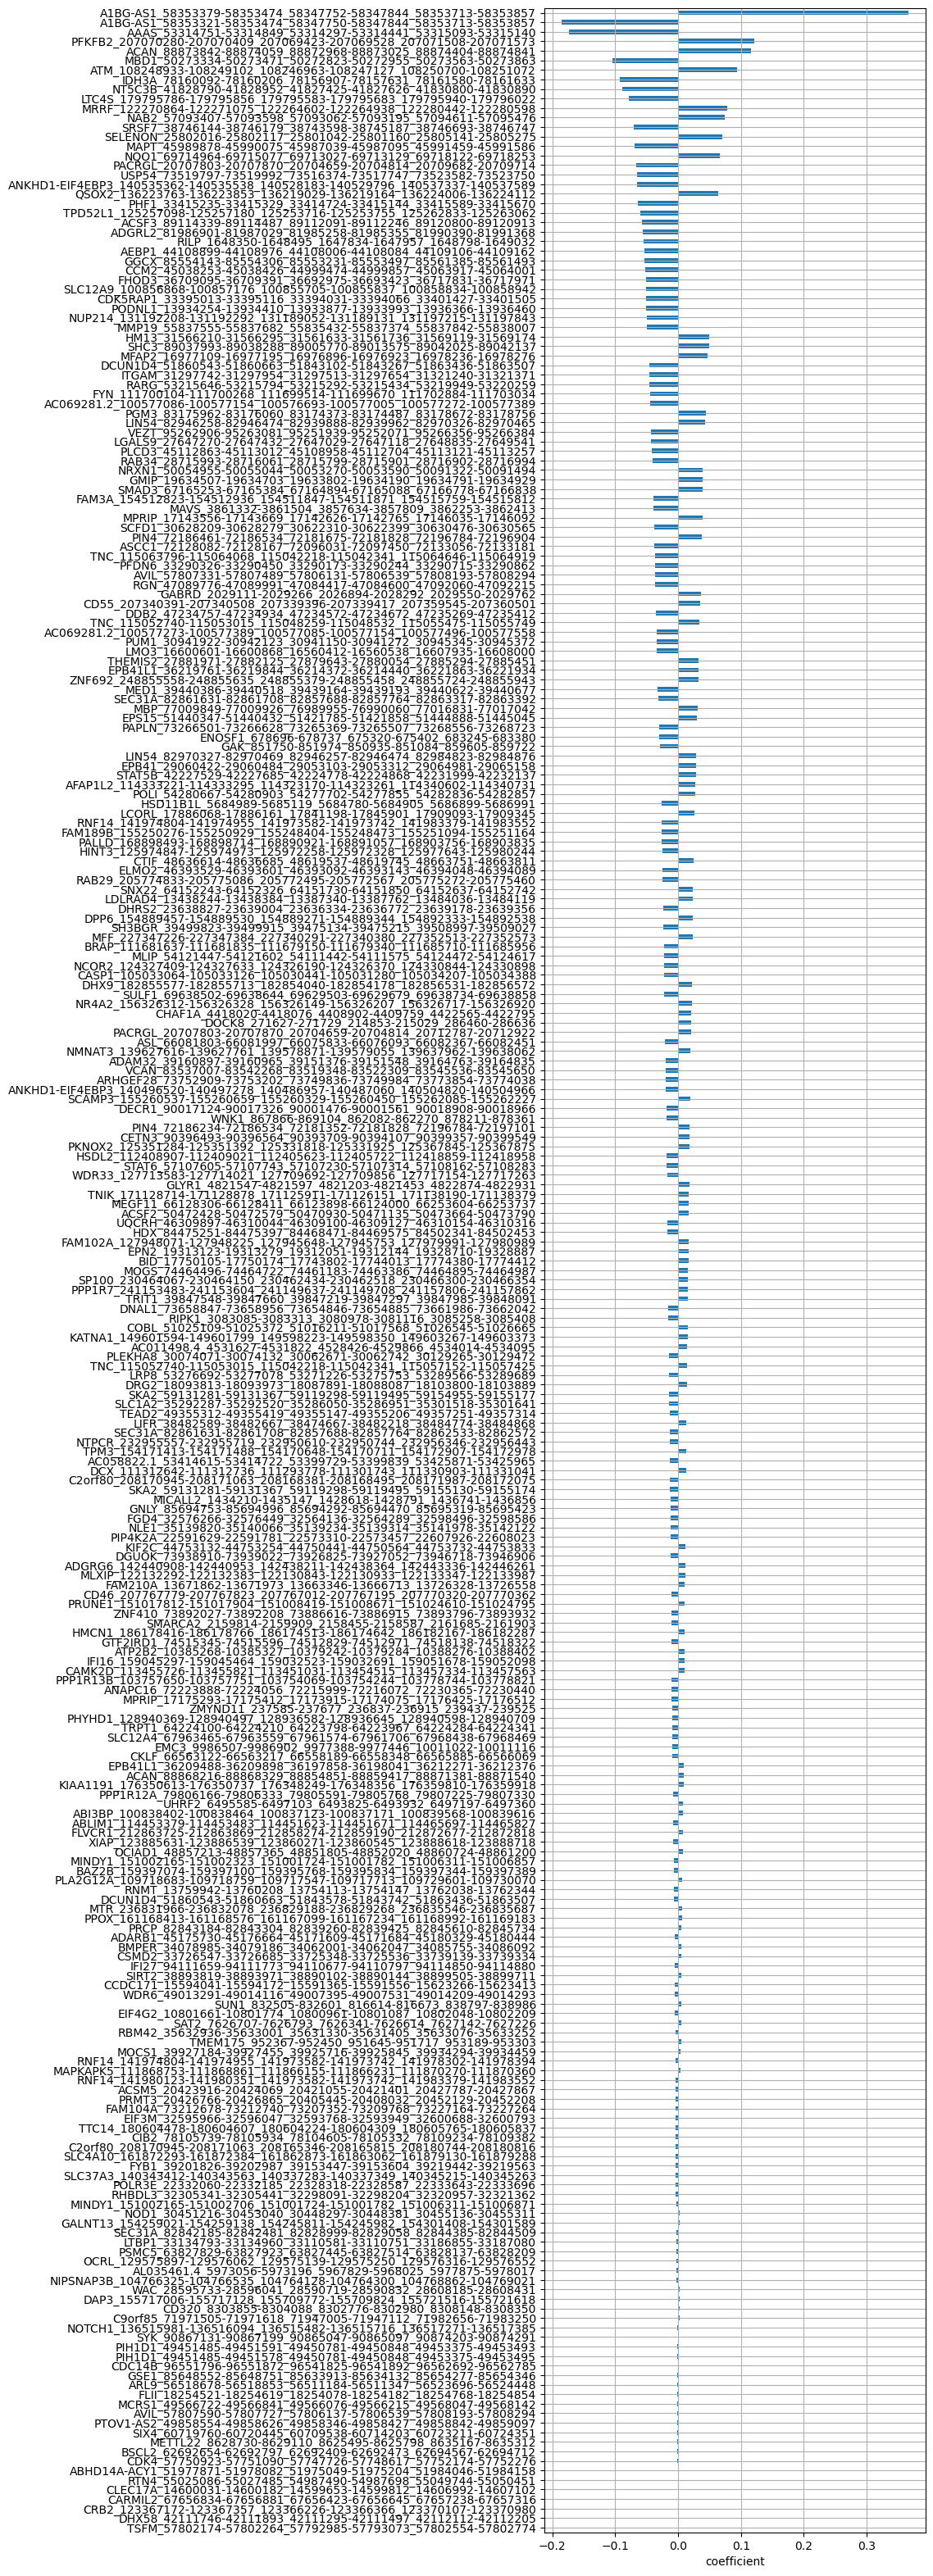

In [15]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 40))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [16]:
#non_zero_coefs.abs().sort_values("coefficient", key=abs, ascending=False)

In [17]:
# Export top ranked prognostic splicing sites
ranked_prognostic_splicing_sites = non_zero_coefs.sort_values("coefficient", key=abs, ascending=False)
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.reset_index()
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.rename(columns={'index':'splicing_site'})
ranked_prognostic_splicing_sites.to_csv(results_dir + "hgat_ranked_prognostic_splicing_sites.csv", index=False)

In [18]:
# Re-create model with optimized parameters found from Grid-Search Cross-Validation
coxnet = CoxnetSurvivalAnalysis(alphas=[0.4], l1_ratio=0.2)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

# Look at ranking of all the splcing sites
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients']).sort_values('coefficients')

0.9538167243578065


coefficients
IDH3A_78160092-78160206_78156907-78157631_78161...     -0.110023
MBD1_50273334-50273471_50272823-50272955_502735...     -0.095470
LTC4S_179795786-179795856_179795583-179795683_1...     -0.085174
NT5C3B_41828790-41828952_41827425-41827626_4183...     -0.079166
ACSF3_89114339-89114487_89112091-89112246_89120...     -0.078704
...                                                          ...
MRRF_122270864-122271075_122264602-122264938_12...      0.075627
ATM_108248933-108249102_108246963-108247127_108...      0.086174
NQO1_69714964-69715077_69713027-69713129_697181...      0.099119
ACAN_88873842-88874059_88872968-88873025_888744...      0.117505
PFKFB2_207070280-207070409_207069423-207069528_...      0.121207

[13027 rows x 1 columns]

Comment: Using all the splicing site features, we get a concordance index of ~0.95, which can be interpreted as the AUC for an ML model for predicting Overall Survival.

---

## Medulloblastoma

In [19]:
# Subset Medulloblastoma samples
mdf = dfms[dfms['short_histology'] == 'Medulloblastoma']

# Split into training and testing set
# Select only splicing sites columns for X feature matrix
X = mdf.iloc[:,46:]

# Normalize the splicing features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fits and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Add column names back into normalized dataframe
Xs.columns = X.columns

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])
print(Xs.head(5))

# Select only OS_status and OS_days columns for y labels
y = mdf[['OS_status', 'OS_days']]
# Convert y (boolean censor and OS_surival) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_status': 'bool', 'OS_days':'f8'})
print(y)

   A1BG-AS1_58353321-58353474_58347750-58347844_58353713-58353857  \
0                                          -0.135222                
1                                          -0.135222                
2                                          -0.135222                
3                                          -0.135222                
4                                          -0.135222                

   A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857  \
0                                           2.974239                
1                                          -0.340425                
2                                          -0.340425                
3                                           4.264270                
4                                          -0.340425                

   AAAS_53314751-53314849_53314297-53314441_53315093-53315140  \
0                                          -0.569291            
1                                       

In [21]:
penalty_factor = np.ones(Xs.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_models/mb_coxnet_feb27/gcv_splicing_v{version}.pkl"


joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_stats/mb_coxnet_feb27/stats_splicing_v{version}.pkl")


results

l1 best : 0.6
 non-zero: 118


/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
7 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to 0.5.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxnet.py", line 249, in fit

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
33        0.097740      0.000618         0.042539        0.000216   
32        0.099928      0.003187         0.042822        0.000255   
34        0.096371      0.000702         0.042769        0.000515   
31        0.098417      0.000947         0.042247        0.000127   
90        0.094802      0.001027         0.042572        0.000223   
..             ...           ...              ...             ...   
240       0.090297      0.000379         0.042418        0.000172   
301       0.090155      0.000450         0.042317        0.000235   
143       0.090267      0.000439         0.042587        0.000394   
200       0.090268      0.000157         0.042329        0.000150   
125       0.090349      0.000294         0.042346        0.000196   

    param_coxnetsurvivalanalysis__alphas  \
33                                [0.05]   
32                                [0.05]   
34                                [0.05]   
31                                [0.05]   
90                                 [0.2]   
..                                   ...   
240                               [0.55]   
301                 [0.7000000000000001]   
143                [0.30000000000000004]   
200                               [0.45]   
125                               [0.25]   

    param_coxnetsurvivalanalysis__l1_ratio  \
33                                     0.6   
32                                    0.55   
34                                    0.65   
31                                     0.5   
90                                     0.3   
..                                     ...   
240                                   0.45   
301                                   0.35   
143                                   0.85   
200                                   0.55   
125                                      1   

                                                params  split0_test_score  \
33   {'coxnetsurvivalanalysis__alphas': [0.05], 'co...           0.691275   
32   {'coxnetsurvivalanalysis__alphas': [0.05], 'co...           0.671141   
34   {'coxnetsurvivalanalysis__alphas': [0.05], 'co...           0.651007   
31   {'coxnetsurvivalanalysis__alphas': [0.05], 'co...           0.718121   
90   {'coxnetsurvivalanalysis__alphas': [0.2], 'cox...           0.637584   
..                                                 ...                ...   
240  {'coxnetsurvivalanalysis__alphas': [0.55], 'co...           0.630872   
301  {'coxnetsurvivalanalysis__alphas': [0.70000000...           0.630872   
143  {'coxnetsurvivalanalysis__alphas': [0.30000000...           0.630872   
200  {'coxnetsurvivalanalysis__alphas': [0.45], 'co...           0.630872   
125  {'coxnetsurvivalanalysis__alphas': [0.25], 'co...           0.630872   

     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
33            0.836364           0.697143           0.816667         0.760362   
32            0.854545           0.657143           0.800000         0.745707   
34            0.830303           0.674286           0.816667         0.743066   
31            0.769697           0.725714           0.750000         0.740883   
90            0.793939           0.691429           0.833333         0.739071   
..                 ...                ...                ...              ...   
240           0.390909           0.402857           0.550000         0.493660   
301           0.390909           0.402857           0.550000         0.493660   
143           0.390909           0.402857           0.550000         0.493660   
200           0.390909           0.402857           0.550000         0.493660   
125           0.390909           0.402857           0.550000         0.493660   

     std_test_score  rank_test_score  
33         0.066551                1  
32         0.083960                2  
34         0.080983                3  
31         0.020381                4  
9

Number of non-zero coefficients: 118


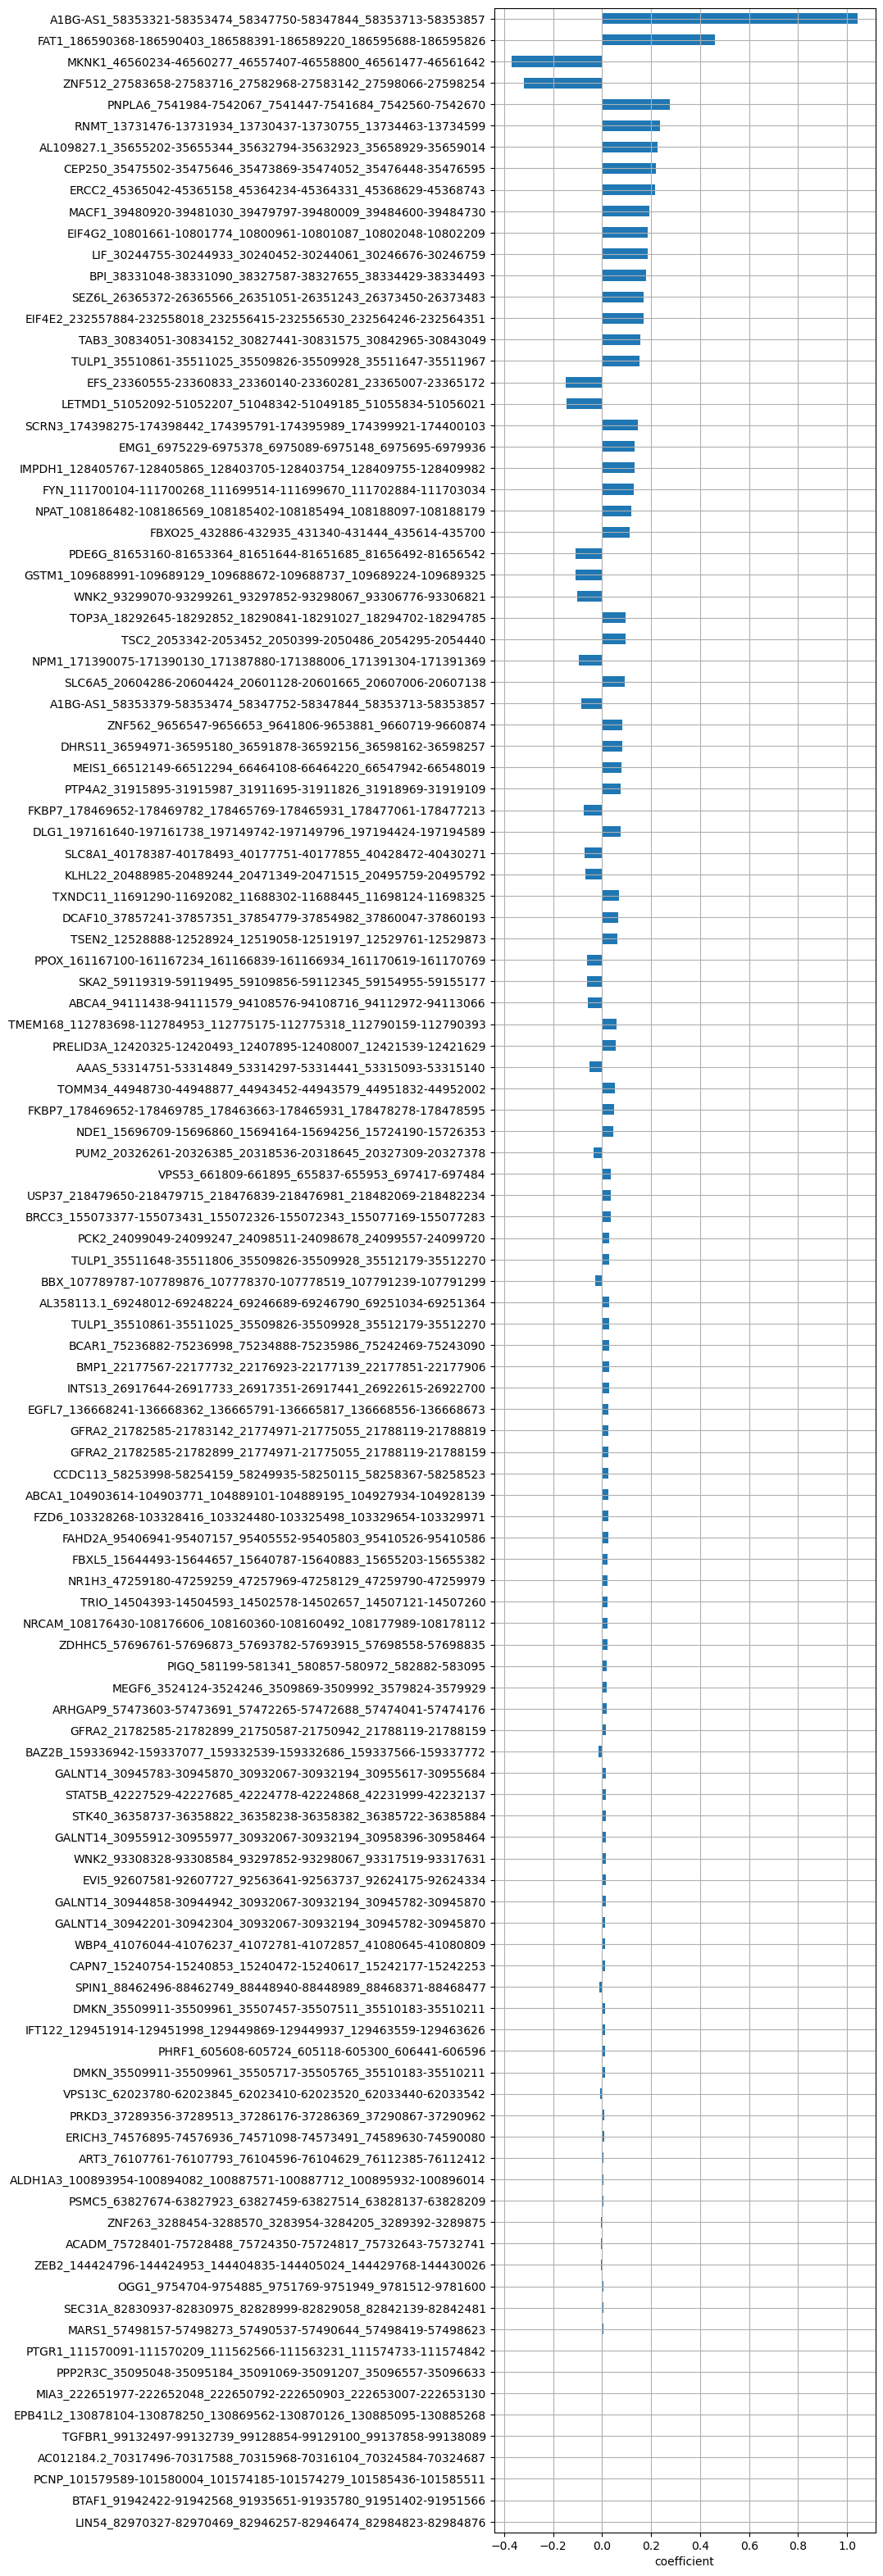

In [22]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 40))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [23]:
# Export top ranked prognostic splicing sites for MB
ranked_prognostic_splicing_sites = non_zero_coefs.sort_values("coefficient", key=abs, ascending=False)
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.reset_index()
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.rename(columns={'index':'splicing_site'})
ranked_prognostic_splicing_sites.to_csv(results_dir + "mb_ranked_prognostic_splicing_sites.csv", index=False)

In [26]:
# Re-create model with optimized parameters found from Grid-Search Cross-Validation
coxnet = CoxnetSurvivalAnalysis(alphas=[0.2], l1_ratio=0.6)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

# Look at ranking of all the splcing sites
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients']).sort_values('coefficients')

0.9450110864745012


coefficients
MKNK1_46560234-46560277_46557407-46558800_46561...     -0.183537
ZNF512_27583658-27583716_27582968-27583142_2759...     -0.106488
PPOX_161167100-161167234_161166839-161166934_16...     -0.073807
PDE6G_81653160-81653364_81651644-81651685_81656...     -0.050071
AD000671.2_35744626-35744738_35744322-35744421_...     -0.048904
...                                                          ...
DLG1_197161640-197161738_197149742-197149796_19...      0.093949
FYN_111700104-111700268_111699514-111699670_111...      0.098614
FAT1_186590368-186590403_186588391-186589220_18...      0.106061
ARHGAP9_57473603-57473691_57472265-57472688_574...      0.138263
EIF4E2_232557884-232558018_232556415-232556530_...      0.183739

[9238 rows x 1 columns]

---

# ATRT

In [27]:
# Subset ATRT samples
adf = dfms[dfms['short_histology'] == 'ATRT']

# Split into training and testing set
# Select only splicing sites columns for X feature matrix
X = adf.iloc[:,46:]

# Normalize the splicing features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fits and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Add column names back into normalized dataframe
Xs.columns = X.columns

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])
print(Xs.head(5))

# Select only OS_status and OS_days columns for y labels
y = adf[['OS_status', 'OS_days']]
# Convert y (boolean censor and OS_surival) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_status': 'bool', 'OS_days':'f8'})
print(y)

   A1BG-AS1_58353321-58353474_58347750-58347844_58353713-58353857  \
0                                          -0.188982                
1                                          -0.188982                
2                                          -0.188982                
3                                          -0.188982                
4                                          -0.188982                

   A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857  \
0                                          -0.339423                
1                                           3.022449                
2                                          -0.339423                
3                                          -0.339423                
4                                          -0.339423                

   AAAS_53314751-53314849_53314297-53314441_53315093-53315140  \
0                                          -0.670071            
1                                       

In [28]:
penalty_factor = np.ones(Xs.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_models/atrt_coxnet_feb27/gcv_splicing_v{version}.pkl"


joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_stats/atrt_coxnet_feb27/stats_splicing_v{version}.pkl")


results

l1 best : 0.75
 non-zero: 25


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
99        0.064763      0.000150         0.031412        0.000210   
118       0.064797      0.000094         0.031431        0.000146   
137       0.065035      0.000154         0.031258        0.000043   
81        0.065618      0.000395         0.031766        0.000259   
100       0.064867      0.000145         0.031344        0.000083   
..             ...           ...              ...             ...   
377       0.066035      0.000275         0.031850        0.000153   
376       0.065276      0.000633         0.031481        0.000220   
375       0.065597      0.000759         0.031658        0.000360   
374       0.065186      0.000481         0.031657        0.000229   
419       0.064851      0.000344         0.031438        0.000262   

    param_coxnetsurvivalanalysis__alphas  \
99                                 [0.2]   
118                               [0.25]   
137                [0.30000000000000004]   
81                 [0.15000000000000002]   
100                                [0.2]   
..                                   ...   
377                 [0.8500000000000001]   
376                 [0.8500000000000001]   
375                 [0.8500000000000001]   
374                 [0.8500000000000001]   
419                 [0.9500000000000001]   

    param_coxnetsurvivalanalysis__l1_ratio  \
99                                    0.75   
118                                   0.65   
137                                   0.55   
81                                     0.9   
100                                    0.8   
..                                     ...   
377                                      1   
376                                   0.95   
375                                    0.9   
374                                   0.85   
419                                      1   

                                                params  split0_test_score  \
99   {'coxnetsurvivalanalysis__alphas': [0.2], 'cox...           0.571429   
118  {'coxnetsurvivalanalysis__alphas': [0.25], 'co...           0.607143   
137  {'coxnetsurvivalanalysis__alphas': [0.30000000...           0.607143   
81   {'coxnetsurvivalanalysis__alphas': [0.15000000...           0.535714   
100  {'coxnetsurvivalanalysis__alphas': [0.2], 'cox...           0.571429   
..                                                 ...                ...   
377  {'coxnetsurvivalanalysis__alphas': [0.85000000...           0.464286   
376  {'coxnetsurvivalanalysis__alphas': [0.85000000...           0.464286   
375  {'coxnetsurvivalanalysis__alphas': [0.85000000...           0.464286   
374  {'coxnetsurvivalanalysis__alphas': [0.85000000...           0.464286   
419  {'coxnetsurvivalanalysis__alphas': [0.95000000...           0.464286   

     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
99            0.789474           0.866667              0.650         0.719392   
118           0.842105           0.800000              0.600         0.712312   
137           0.789474           0.800000              0.650         0.711654   
81            0.789474           0.866667              0.650         0.710464   
100           0.789474           0.866667              0.600         0.706892   
..                 ...                ...                ...              ...   
377           0.447368           0.366667              0.425         0.425830   
376           0.447368           0.366667              0.425         0.425830   
375           0.447368           0.366667              0.425         0.425830   
374           0.447368           0.366667              0.425         0.425830   
419           0.447368           0.366667              0.425         0.425830   

     std_test_score  rank_test_score  
99         0.115444                1  
118        0.109784                2  
137        0.084535                3  
81         0.127314                4  
1

Number of non-zero coefficients: 25


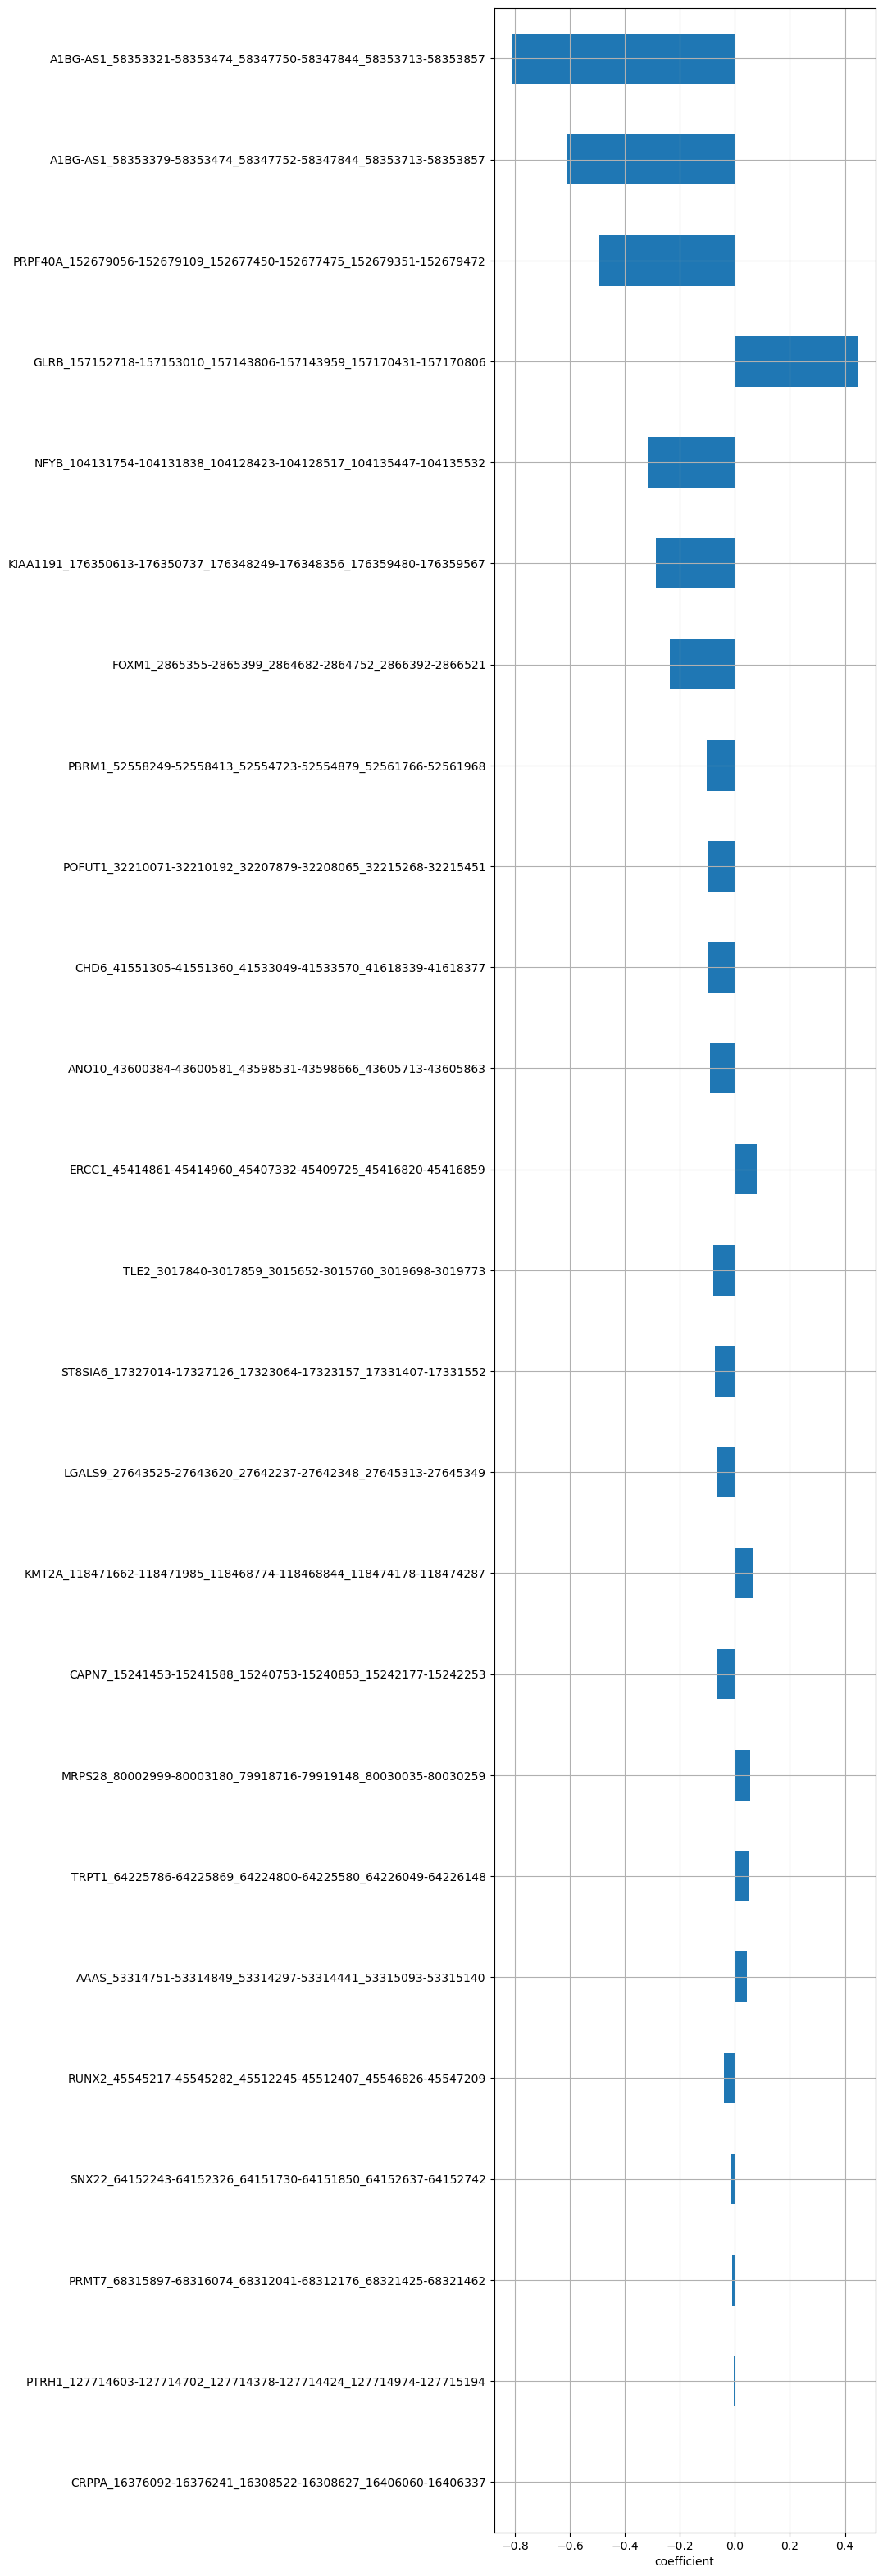

In [29]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 40))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [30]:
# Export top ranked prognostic splicing sites for MB
ranked_prognostic_splicing_sites = non_zero_coefs.sort_values("coefficient", key=abs, ascending=False)
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.reset_index()
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.rename(columns={'index':'splicing_site'})
ranked_prognostic_splicing_sites.to_csv(results_dir + "atrt_ranked_prognostic_splicing_sites.csv", index=False)

In [31]:
# Re-create model with optimized parameters found from Grid-Search Cross-Validation
coxnet = CoxnetSurvivalAnalysis(alphas=[0.2], l1_ratio=0.75)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

# Look at ranking of all the splcing sites
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients']).sort_values('coefficients')

0.9865951742627346


coefficients
RUNX2_45545217-45545282_45512245-45512407_45546...     -0.298709
PRPF40A_152679056-152679109_152677450-152677475...     -0.282977
GSTZ1_77327912-77328037_77327471-77327552_77329...     -0.269542
BID_17743803-17744013_17739348-17739488_1777438...     -0.179487
PBRM1_52558249-52558413_52554723-52554879_52561...     -0.179000
...                                                          ...
TLE1_81634097-81634301_81620440-81620557_816521...      0.076838
CD164_109370411-109370467_109366513-109369017_1...      0.121540
ERCC1_45414861-45414960_45407332-45409725_45416...      0.151664
ENKD1_67664996-67665168_67663936-67664062_67666...      0.163947
GLRB_157152718-157153010_157143806-157143959_15...      0.494899

[6794 rows x 1 columns]

---

# LGATs

In [32]:
# Subset LGAT samples
ldf = dfms[dfms['short_histology'] == 'LGAT']

# Split into training and testing set
# Select only splicing sites columns for X feature matrix
X = ldf.iloc[:,46:]

# Normalize the splicing features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fits and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Add column names back into normalized dataframe
Xs.columns = X.columns

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])
print(Xs.head(5))

# Select only OS_status and OS_days columns for y labels
y = ldf[['OS_status', 'OS_days']]
# Convert y (boolean censor and OS_surival) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_status': 'bool', 'OS_days':'f8'})
print(y)

   A1BG-AS1_58353321-58353474_58347750-58347844_58353713-58353857  \
0                                          -0.232925                
1                                          -0.232925                
2                                          -0.232925                
3                                          -0.232925                
4                                          -0.232925                

   A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857  \
0                                          -0.373122                
1                                          -0.373122                
2                                          -0.373122                
3                                          -0.373122                
4                                          -0.373122                

   A2ML1_8849669-8849759_8848719-8848914_8850159-8850274  \
0                                           -0.07036       
1                                           -0.070

In [33]:
penalty_factor = np.ones(Xs.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_models/lgat_coxnet_feb27/gcv_splicing_v{version}.pkl"


joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_stats/lgat_coxnet_feb27/stats_splicing_v{version}.pkl")


results

/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.5. Details: 
Traceback (most recent call last):
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sksurv/base.py", line 98, in score
    result = concordance_index_censored(y[name_event], y[name_time], risk_score)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9

l1 best : 0.1
 non-zero: 337


/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.5. Details: 
Traceback (most recent call last):
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sksurv/base.py", line 98, in score
    result = concordance_index_censored(y[name_event], y[name_time], risk_score)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
86        0.099230      0.003560         0.040074        0.000153   
46        0.098188      0.003262         0.040491        0.000402   
28        0.095059      0.002251         0.040133        0.000534   
21        0.152310      0.019237         0.040686        0.000727   
66        0.097526      0.003044         0.040191        0.000342   
..             ...           ...              ...             ...   
316       0.094613      0.001564         0.040683        0.000426   
90        0.092550      0.000872         0.040342        0.000379   
149       0.094288      0.001762         0.039982        0.000173   
358       0.092262      0.002370         0.040012        0.000319   
150       0.092648      0.001238         0.039938        0.000272   

    param_coxnetsurvivalanalysis__alphas  \
86                                 [0.2]   
46                                 [0.1]   
28                                [0.05]   
21                                [0.05]   
66                 [0.15000000000000002]   
..                                   ...   
316                               [0.75]   
90                                 [0.2]   
149                [0.35000000000000003]   
358                 [0.8500000000000001]   
150                [0.35000000000000003]   

    param_coxnetsurvivalanalysis__l1_ratio  \
86                                     0.1   
46                                     0.2   
28                                    0.35   
21                                    0.01   
66                                    0.15   
..                                     ...   
316                                   0.05   
90                                     0.3   
149                                    0.1   
358                                   0.05   
150                                   0.15   

                                                params  split0_test_score  \
86   {'coxnetsurvivalanalysis__alphas': [0.2], 'cox...           0.777778   
46   {'coxnetsurvivalanalysis__alphas': [0.1], 'cox...           0.777778   
28   {'coxnetsurvivalanalysis__alphas': [0.05], 'co...           0.500000   
21   {'coxnetsurvivalanalysis__alphas': [0.05], 'co...           0.555556   
66   {'coxnetsurvivalanalysis__alphas': [0.15000000...           0.388889   
..                                                 ...                ...   
316  {'coxnetsurvivalanalysis__alphas': [0.75], 'co...           0.388889   
90   {'coxnetsurvivalanalysis__alphas': [0.2], 'cox...           0.527778   
149  {'coxnetsurvivalanalysis__alphas': [0.35000000...           0.055556   
358  {'coxnetsurvivalanalysis__alphas': [0.85000000...           0.111111   
150  {'coxnetsurvivalanalysis__alphas': [0.35000000...           0.055556   

     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
86            0.818182              1.000                0.5         0.773990   
46            0.772727              1.000                0.5         0.762626   
28            0.772727              1.000                0.5         0.693182   
21            0.818182              0.850                0.5         0.680934   
66            0.750000              1.000                0.5         0.659722   
..                 ...                ...                ...              ...   
316           0.488636              0.200                0.5         0.394381   
90            0.346591              0.200                0.5         0.393592   
149           0.511364              0.475                0.5         0.385480   
358           0.488636              0.250                0.5         0.337437   
150           0.488636              0.200                0.5         0.311048   

     std_test_score  rank_test_score  
86         0.178968                1  
46         0.177236                2  
28         0.209227                3  
21         0.154820                4  
6

Number of non-zero coefficients: 337


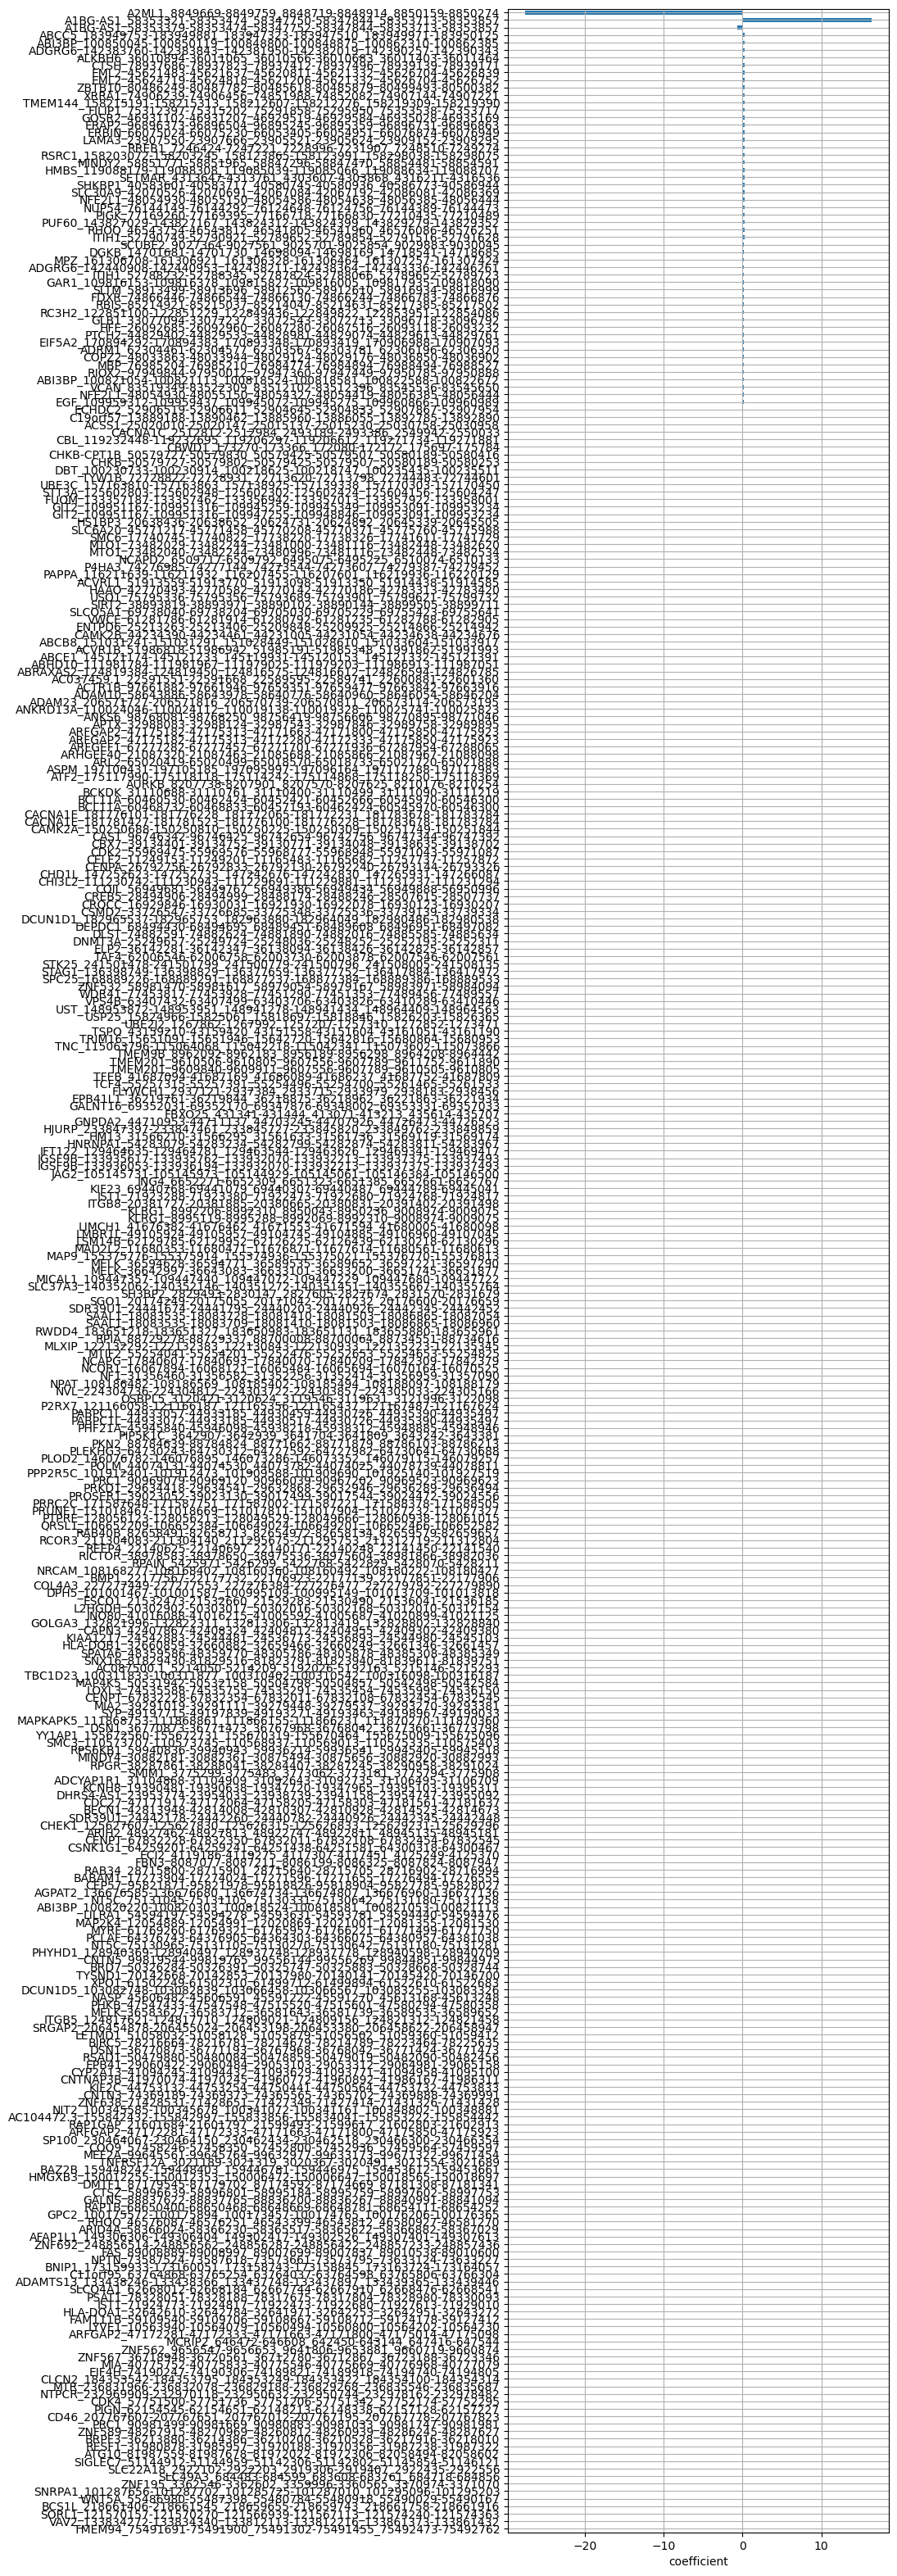

In [34]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 40))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [35]:
# Export top ranked prognostic splicing sites for MB
ranked_prognostic_splicing_sites = non_zero_coefs.sort_values("coefficient", key=abs, ascending=False)
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.reset_index()
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.rename(columns={'index':'splicing_site'})
ranked_prognostic_splicing_sites.to_csv(results_dir + "lgat_ranked_prognostic_splicing_sites.csv", index=False)

In [36]:
# Re-create model with optimized parameters found from Grid-Search Cross-Validation
coxnet = CoxnetSurvivalAnalysis(alphas=[0.2], l1_ratio=0.1)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

# Look at ranking of all the splcing sites
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients']).sort_values('coefficients')

0.9113680154142582


coefficients
SMIM1_3775299-3775483_3773062-3773181_3775794-3...     -0.674042
RPGR_38287861-38288041_38284407-38287245_382909...     -0.674010
MINDY4_30882181-30882361_30875494-30875656_3088...     -0.673998
ADCYAP1R1_31104868-31104909_31092643-31092735_3...     -0.673898
LILRA1_54594197-54594278_54593631-54593781_5459...     -0.515094
...                                                          ...
UBE3C_157163810-157163863_157138925-157139338_1...      0.276509
CHKB-CPT1B_50579727-50579830_50579425-50579507_...      0.276527
CHKB_50579727-50579802_50579425-50579507_505801...      0.276527
ACSS1_25020010-25020147_25015137-25015230_25030...      0.276569
TBC1D23_100311833-100311877_100310402-100310542...      0.342675

[8534 rows x 1 columns]

---

# Ganglioglioma

In [37]:
# Subset LGAT samples
gdf = dfms[dfms['short_histology'] == 'Ganglioglioma']

# Split into training and testing set
# Select only splicing sites columns for X feature matrix
X = gdf.iloc[:,46:]

# Normalize the splicing features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fits and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Add column names back into normalized dataframe
Xs.columns = X.columns

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])
print(Xs.head(5))

# Select only OS_status and OS_days columns for y labels
y = gdf[['OS_status', 'OS_days']]
# Convert y (boolean censor and OS_surival) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_status': 'bool', 'OS_days':'f8'})
print(y)

   A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857  \
0                                           -0.41663                
1                                           -0.41663                
2                                           -0.41663                
3                                           -0.41663                
4                                           -0.41663                

   AAAS_53314751-53314849_53314297-53314441_53315093-53315140  \
0                                           1.731711            
1                                          -0.506354            
2                                          -0.506354            
3                                          -0.506354            
4                                          -0.506354            

   AAK1_69480860-69480961_69465845-69466551_69495984-69496080  \
0                                          -0.282612            
1                                          -0.282612            

In [ ]:
penalty_factor = np.ones(Xs.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_models/gng_coxnet_feb27/gcv_splicing_v{version}.pkl"


joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_stats/gng_coxnet_feb27/stats_splicing_v{version}.pkl")


results

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 40))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [ ]:
# Export top ranked prognostic splicing sites for MB
ranked_prognostic_splicing_sites = non_zero_coefs.sort_values("coefficient", key=abs, ascending=False)
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.reset_index()
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.rename(columns={'index':'splicing_site'})
ranked_prognostic_splicing_sites.to_csv(results_dir + "gng_ranked_prognostic_splicing_sites.csv", index=False)

In [ ]:
# Re-create model with optimized parameters found from Grid-Search Cross-Validation
coxnet = CoxnetSurvivalAnalysis(alphas=[0.4], l1_ratio=0.2)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

# Look at ranking of all the splcing sites
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients']).sort_values('coefficients')

---

# Craniopharyngioma

In [39]:
# Subset LGAT samples
cdf = dfms[dfms['short_histology'] == 'Craniopharyngioma']

# Split into training and testing set
# Select only splicing sites columns for X feature matrix
X = cdf.iloc[:,46:]

# Normalize the splicing features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fits and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Add column names back into normalized dataframe
Xs.columns = X.columns

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])
print(Xs.head(5))

# Select only OS_status and OS_days columns for y labels
y = cdf[['OS_status', 'OS_days']]
# Convert y (boolean censor and OS_surival) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_status': 'bool', 'OS_days':'f8'})
print(y)

   A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857  \
0                                          -0.598103                
1                                          -0.598103                
2                                          -0.598103                
3                                           1.843899                
4                                           1.198312                

   AAAS_53314751-53314849_53314297-53314441_53315093-53315140  \
0                                          -0.267233            
1                                          -0.267233            
2                                          -0.267233            
3                                          -0.267233            
4                                          -0.267233            

   AAK1_69480860-69480961_69465845-69466551_69495984-69496080  \
0                                           -0.26718            
1                                           -0.26718            

In [40]:
penalty_factor = np.ones(Xs.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_models/cranio_coxnet_feb27/gcv_splicing_v{version}.pkl"


joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_stats/cranio_coxnet_feb27/stats_splicing_v{version}.pkl")


results

/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.5. Details: 
Traceback (most recent call last):
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sksurv/base.py", line 98, in score
    result = concordance_index_censored(y[name_event], y[name_time], risk_score)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9

l1 best : 0.35
 non-zero: 56


/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.5. Details: 
Traceback (most recent call last):
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sksurv/base.py", line 98, in score
    result = concordance_index_censored(y[name_event], y[name_time], risk_score)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
44        0.053419      0.000584         0.024822        0.000121   
43        0.055013      0.000896         0.024871        0.000166   
84        0.061471      0.002154         0.024899        0.000309   
63        0.060422      0.001950         0.025056        0.000521   
28        0.051862      0.000405         0.024749        0.000276   
..             ...           ...              ...             ...   
198       0.051953      0.000465         0.025226        0.000119   
197       0.051590      0.000755         0.025329        0.000279   
196       0.051264      0.000190         0.024826        0.000095   
419       0.050974      0.000342         0.024887        0.000232   
53        0.051399      0.000211         0.024779        0.000187   

    param_coxnetsurvivalanalysis__alphas  \
44                                 [0.1]   
43                                 [0.1]   
84                                 [0.2]   
63                 [0.15000000000000002]   
28                                [0.05]   
..                                   ...   
198                               [0.45]   
197                               [0.45]   
196                               [0.45]   
419                 [0.9500000000000001]   
53                                 [0.1]   

    param_coxnetsurvivalanalysis__l1_ratio  \
44                                     0.1   
43                                    0.05   
84                                    0.01   
63                                    0.01   
28                                    0.35   
..                                     ...   
198                                   0.45   
197                                    0.4   
196                                   0.35   
419                                      1   
53                                    0.55   

                                                params  split0_test_score  \
44   {'coxnetsurvivalanalysis__alphas': [0.1], 'cox...                0.5   
43   {'coxnetsurvivalanalysis__alphas': [0.1], 'cox...                0.5   
84   {'coxnetsurvivalanalysis__alphas': [0.2], 'cox...                0.5   
63   {'coxnetsurvivalanalysis__alphas': [0.15000000...                0.5   
28   {'coxnetsurvivalanalysis__alphas': [0.05], 'co...                0.5   
..                                                 ...                ...   
198  {'coxnetsurvivalanalysis__alphas': [0.45], 'co...                0.5   
197  {'coxnetsurvivalanalysis__alphas': [0.45], 'co...                0.5   
196  {'coxnetsurvivalanalysis__alphas': [0.45], 'co...                0.5   
419  {'coxnetsurvivalanalysis__alphas': [0.95000000...                0.5   
53   {'coxnetsurvivalanalysis__alphas': [0.1], 'cox...                0.5   

     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
44            0.666667               1.00                0.5         0.666667   
43            0.666667               1.00                0.5         0.666667   
84            0.666667               1.00                0.5         0.666667   
63            0.666667               1.00                0.5         0.666667   
28            0.666667               1.00                0.5         0.666667   
..                 ...                ...                ...              ...   
198           0.416667               0.00                0.5         0.354167   
197           0.416667               0.00                0.5         0.354167   
196           0.416667               0.00                0.5         0.354167   
419           0.416667               0.00                0.5         0.354167   
53            0.166667               0.25                0.5         0.354167   

     std_test_score  rank_test_score  
44         0.204124                1  
43         0.204124                1  
84         0.204124                1  
63         0.204124                1  
2

Number of non-zero coefficients: 56


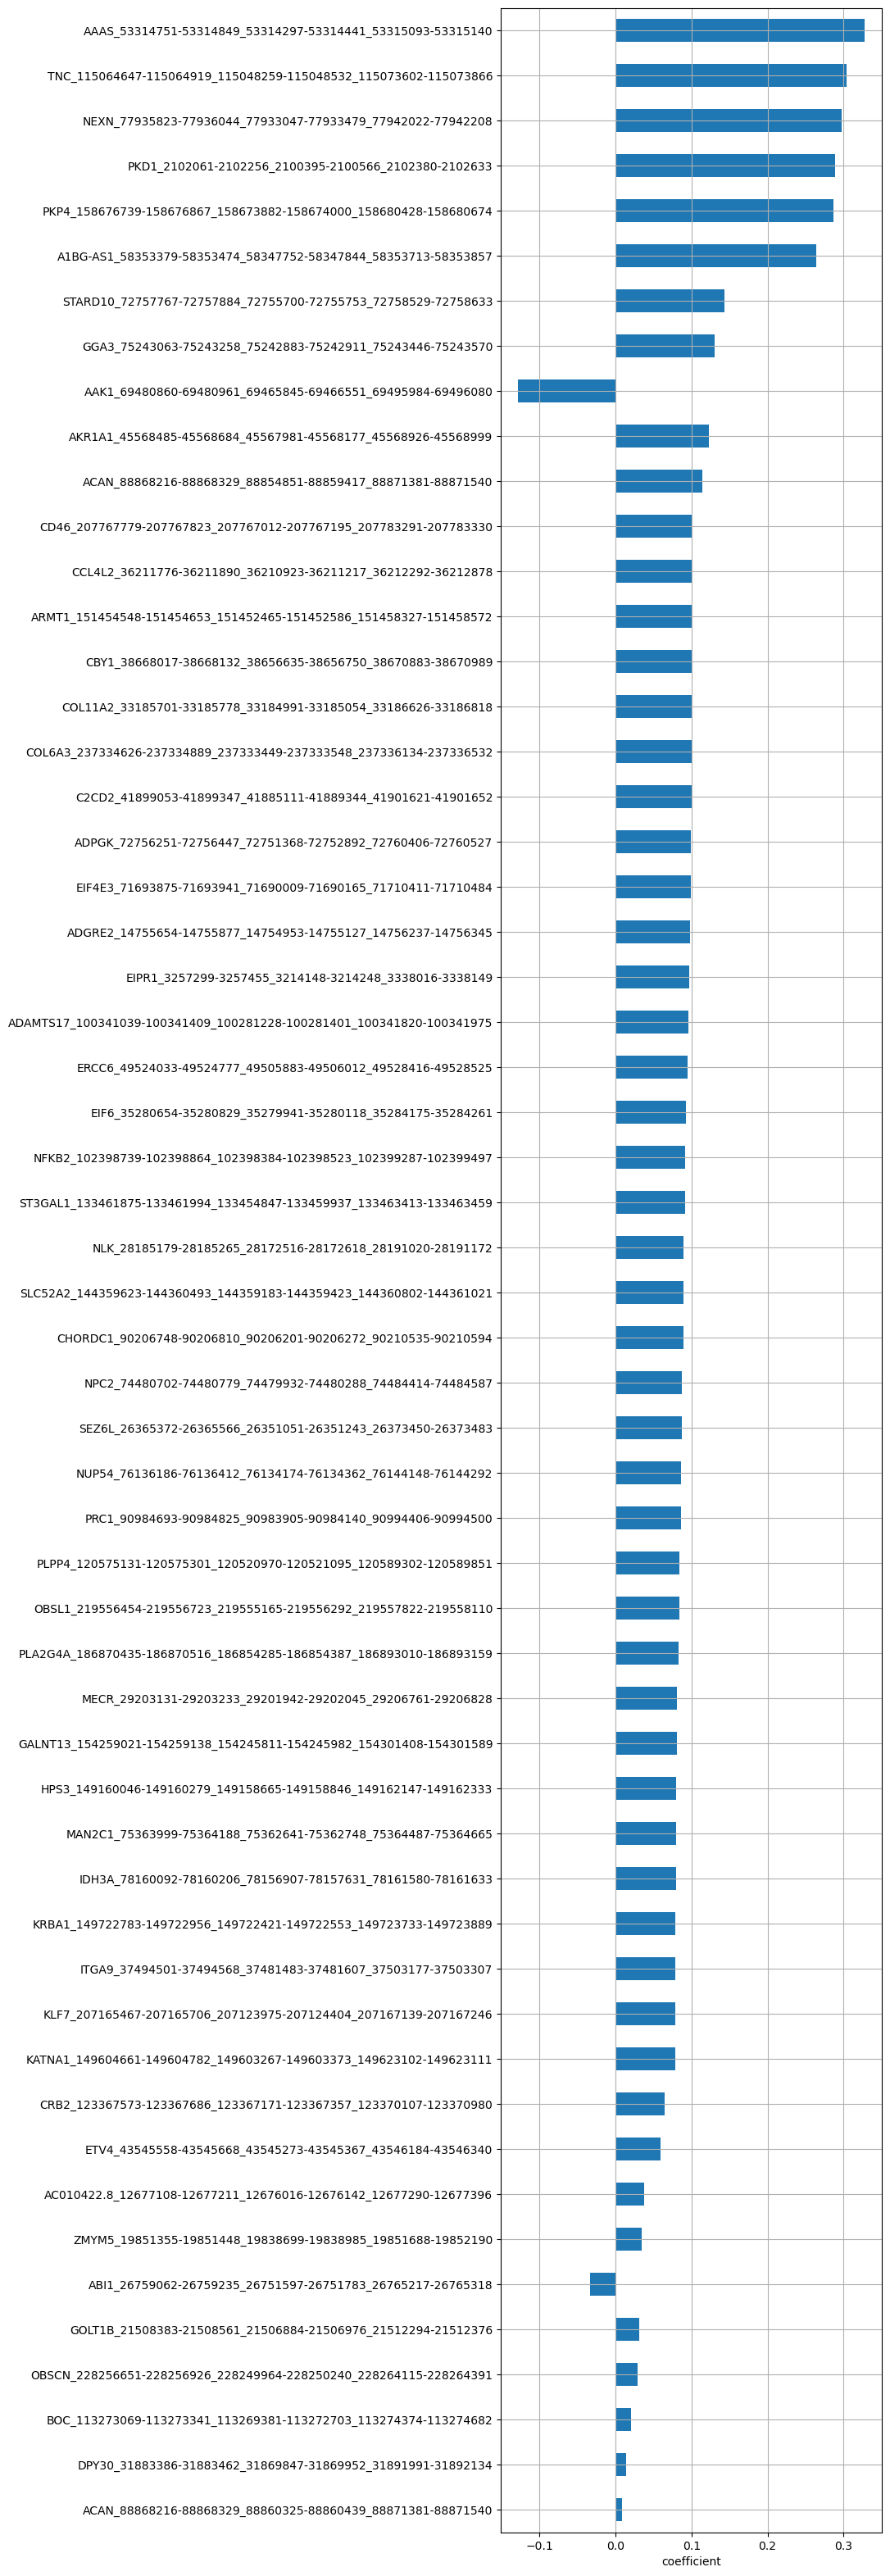

In [41]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 40))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [42]:
# Export top ranked prognostic splicing sites for MB
ranked_prognostic_splicing_sites = non_zero_coefs.sort_values("coefficient", key=abs, ascending=False)
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.reset_index()
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.rename(columns={'index':'splicing_site'})
ranked_prognostic_splicing_sites.to_csv(results_dir + "cranio_ranked_prognostic_splicing_sites.csv", index=False)

In [43]:
# Re-create model with optimized parameters found from Grid-Search Cross-Validation
coxnet = CoxnetSurvivalAnalysis(alphas=[0.1], l1_ratio=0.1)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

# Look at ranking of all the splcing sites
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients']).sort_values('coefficients')

1.0


coefficients
A1BG-AS1_58353379-58353474_58347752-58347844_58...      0.000000
PIN4_72186234-72186534_72181352-72181828_721967...      0.000000
PIKFYVE_208347859-208348023_208346049-208346147...      0.000000
PIKFYVE_208285726-208285933_208273583-208273733...      0.000000
PIKFYVE_208285726-208285933_208271510-208271691...      0.000000
...                                                          ...
KLF7_207165467-207165706_207123975-207124404_20...      0.084745
TNC_115064647-115064919_115048259-115048532_115...      0.110045
NEXN_77935823-77936044_77933047-77933479_779420...      0.111851
PKP4_158676739-158676867_158673882-158674000_15...      0.112355
PKD1_2102061-2102256_2100395-2100566_2102380-21...      0.112516

[5303 rows x 1 columns]

---

# Ependymoma

In [44]:
# Subset LGAT samples
edf = dfms[dfms['short_histology'] == 'Ependymoma']

# Split into training and testing set
# Select only splicing sites columns for X feature matrix
X = edf.iloc[:,46:]

# Normalize the splicing features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fits and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Add column names back into normalized dataframe
Xs.columns = X.columns

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])
print(Xs.head(5))

# Select only OS_status and OS_days columns for y labels
y = edf[['OS_status', 'OS_days']]
# Convert y (boolean censor and OS_surival) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_status': 'bool', 'OS_days':'f8'})
print(y)

   A1BG-AS1_58353321-58353474_58347750-58347844_58353713-58353857  \
0                                          -0.243485                
1                                          -0.243485                
2                                          -0.243485                
3                                          -0.243485                
4                                          -0.243485                

   A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857  \
0                                          -0.592656                
1                                          -0.592656                
2                                           1.825565                
3                                          -0.592656                
4                                          -0.592656                

   A2ML1_8836255-8836339_8835506-8835666_8837439-8837566  \
0                                          -0.110432       
1                                          -0.1104

In [47]:
penalty_factor = np.ones(Xs.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_models/epn_coxnet_feb27/gcv_splicing_v{version}.pkl"


joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_stats/epn_coxnet_feb27/stats_splicing_v{version}.pkl")


results

l1 best : 0.01
 non-zero: 2199


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
378       0.116871      0.003639         0.034894        0.000042   
399       0.117226      0.003140         0.034895        0.000114   
357       0.115866      0.004197         0.034862        0.000197   
336       0.116584      0.003757         0.034871        0.000112   
84        0.108770      0.004519         0.034804        0.000116   
..             ...           ...              ...             ...   
133       0.073781      0.000208         0.034674        0.000201   
77        0.074431      0.000411         0.035093        0.000190   
95        0.073676      0.000122         0.034907        0.000360   
94        0.074534      0.000473         0.034949        0.000220   
113       0.073964      0.000331         0.035038        0.000273   

    param_coxnetsurvivalanalysis__alphas  \
378                                [0.9]   
399                 [0.9500000000000001]   
357                 [0.8500000000000001]   
336                                [0.8]   
84                                 [0.2]   
..                                   ...   
133                [0.30000000000000004]   
77                 [0.15000000000000002]   
95                                 [0.2]   
94                                 [0.2]   
113                               [0.25]   

    param_coxnetsurvivalanalysis__l1_ratio  \
378                                   0.01   
399                                   0.01   
357                                   0.01   
336                                   0.01   
84                                    0.01   
..                                     ...   
133                                   0.35   
77                                     0.7   
95                                    0.55   
94                                     0.5   
113                                    0.4   

                                                params  split0_test_score  \
378  {'coxnetsurvivalanalysis__alphas': [0.9], 'cox...           0.813953   
399  {'coxnetsurvivalanalysis__alphas': [0.95000000...           0.813953   
357  {'coxnetsurvivalanalysis__alphas': [0.85000000...           0.813953   
336  {'coxnetsurvivalanalysis__alphas': [0.8], 'cox...           0.837209   
84   {'coxnetsurvivalanalysis__alphas': [0.2], 'cox...           0.790698   
..                                                 ...                ...   
133  {'coxnetsurvivalanalysis__alphas': [0.30000000...           0.662791   
77   {'coxnetsurvivalanalysis__alphas': [0.15000000...           0.662791   
95   {'coxnetsurvivalanalysis__alphas': [0.2], 'cox...           0.662791   
94   {'coxnetsurvivalanalysis__alphas': [0.2], 'cox...           0.720930   
113  {'coxnetsurvivalanalysis__alphas': [0.25], 'co...           0.720930   

     split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
378           0.747253           0.625000           0.705882         0.723022   
399           0.747253           0.625000           0.705882         0.723022   
357           0.725275           0.625000           0.691176         0.713851   
336           0.703297           0.583333           0.676471         0.700077   
84            0.692308           0.625000           0.676471         0.696119   
..                 ...                ...                ...              ...   
133           0.521978           0.166667           0.463235         0.453668   
77            0.521978           0.208333           0.389706         0.445702   
95            0.521978           0.208333           0.360294         0.438349   
94            0.521978           0.166667           0.338235         0.436953   
113           0.521978           0.166667           0.308824         0.429600   

     std_test_score  rank_test_score  
378        0.068479                1  
399        0.068479                1  
357        0.068117                3  
336        0.090832                4  
8

In [48]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

# _, ax = plt.subplots(figsize=(6, 40))
# non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
# ax.set_xlabel("coefficient")
# ax.grid(True)

Number of non-zero coefficients: 2199


In [49]:
# Export top ranked prognostic splicing sites for MB
ranked_prognostic_splicing_sites = non_zero_coefs.sort_values("coefficient", key=abs, ascending=False)
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.reset_index()
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.rename(columns={'index':'splicing_site'})
ranked_prognostic_splicing_sites.to_csv(results_dir + "epn_ranked_prognostic_splicing_sites.csv", index=False)

In [50]:
# Re-create model with optimized parameters found from Grid-Search Cross-Validation
coxnet = CoxnetSurvivalAnalysis(alphas=[0.9], l1_ratio=0.01)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

# Look at ranking of all the splcing sites
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients']).sort_values('coefficients')

0.9242424242424242


coefficients
MEIS2_36894717-36894812_36891020-36892459_36895...     -0.176147
FAM81B_95436800-95436906_95428602-95428732_9544...     -0.153939
TMEM232_110638198-110638355_110627780-110627880...     -0.138654
SYNC_32684010-32684089_32679905-32681860_326842...     -0.138409
C4orf47_185436284-185436359_185436045-185436183...     -0.137513
...                                                          ...
STK25_241501478-241501799_241500779-241500796_2...      0.178204
DNMT3A_25249657-25249724_25248036-25248252_2525...      0.178581
LZTFL1_45827356-45827459_45823315-45826332_4582...      0.181778
ELN_74045222-74045293_74041215-74041251_7404669...      0.187885
SUN1_849923-850033_849519-849603_851383-851481          0.202783

[7504 rows x 1 columns]

---

## Splice site: A1BG-AS1_58353321-58353474_58347750-58347844_58353713-58353857

In [51]:
data = {
  "Tumor": ["All", "Medulloblastoma", "ATRT", "HGAT", "LGAT", "Craniopharyngioma", "Ganglioglioma", "Ependymoma"],
  "Cox_Coefficient": [0.11733086842091, 1.04442208742005, -0.813475685825055, -0.18530085139392, 16.3761906659084, "NA", "NA", -3.17053092899116],
  "Rank": [1, 1, 1, 2, 2, "NA", "NA", 1],
  "Sample_Size": [858, 106, 29, 153, 203, 30, 39, 83]
}
# Tumor = ["All", "Medulloblastoma", "ATRT", "HGAT", "LGAT", "Craniopharyngioma", "Ganglioglioma", "Ependymoma"]
# Cox_Coefficient = [0.11733086842091, 1.04442208742005, -0.813475685825055, -0.18530085139392, 16.3761906659084, "NA", "NA", -3.17053092899116]
# Rank = [1, 1, 1, 2, 2, "NA", "NA", 1]
pd.DataFrame(data)

Tumor Cox_Coefficient Rank  Sample_Size
0                All        0.117331    1          858
1    Medulloblastoma        1.044422    1          106
2               ATRT       -0.813476    1           29
3               HGAT       -0.185301    2          153
4               LGAT       16.376191    2          203
5  Craniopharyngioma              NA   NA           30
6      Ganglioglioma              NA   NA           39
7         Ependymoma       -3.170531    1           83

## Splice site: A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857

In [52]:
data2 = {
  "Tumor": ["All", "Medulloblastoma", "ATRT", "HGAT", "LGAT", "Craniopharyngioma", "Ganglioglioma", "Ependymoma"],
  "Cox_Coefficient": [0.109863819277972, -0.0865458861083362, -0.610111780419829, 0.366007813772713, -0.67859233491686, 0.264217885134598, "NA", 0.594135424991888],
  "Rank": [2, 33, 2, 1, 3, 6, "NA", 2],
  "Sample_Size": [858, 106, 29, 153, 203, 30, 39, 83]
}
# Tumor = ["All", "Medulloblastoma", "ATRT", "HGAT", "LGAT", "Craniopharyngioma", "Ganglioglioma", "Ependymoma"]
# Cox_Coefficient = [0.11733086842091, 1.04442208742005, -0.813475685825055, -0.18530085139392, 16.3761906659084, "NA", "NA", -3.17053092899116]
# Rank = [1, 1, 1, 2, 2, "NA", "NA", 1]
pd.DataFrame(data2)

Tumor Cox_Coefficient Rank  Sample_Size
0                All        0.109864    2          858
1    Medulloblastoma       -0.086546   33          106
2               ATRT       -0.610112    2           29
3               HGAT        0.366008    1          153
4               LGAT       -0.678592    3          203
5  Craniopharyngioma        0.264218    6           30
6      Ganglioglioma              NA   NA           39
7         Ependymoma        0.594135    2           83